In [1]:
# jbu vs strided vs ours (memory, time)
# # Imports
import torch
from torch import nn
torch.cuda.empty_cache()
from torch.nn.functional import interpolate

from hr_dv2 import HighResDV2
import hr_dv2.transform as tr
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from time import time_ns

torch.manual_seed(0)
np.random.seed(0)

from featup.util import norm, unnorm
use_norm = True


/home/ronan/HR-Dv2/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_img(path: str, l: int) -> tuple[torch.Tensor, np.ndarray]:
    temp_img = Image.open(path)
    h, w = temp_img.height, temp_img.width
    #transform = tr.closest_crop(h, w) #tr.get_input_transform(L, L)
    transform = tr.get_input_transform(l, l)
    tensor, img = tr.load_image(path, transform)
    H, W = img.height, img.width
    return tensor, np.array(img)

In [3]:

def get_net(strided=False) -> nn.Module:
    net = HighResDV2("dinov2_vits14_reg", 4, dtype=torch.float16) #dino_vits8 #dinov2_vits14_reg
    net.interpolation_mode = 'nearest-exact'
    net.eval()
    net.cuda()

    fwd_shift, inv_shift = tr.get_shift_transforms([1, 2], 'Moore')
    fwd_flip, inv_flip = tr.get_flip_transforms()
    fwd, inv = tr.combine_transforms(fwd_shift, fwd_flip, inv_shift, inv_flip)
    if strided:
        net.set_transforms([], [])
    else:
        net.set_transforms(fwd_shift, inv_shift)
    return net

In [4]:
def get_jbu() -> torch.nn.Module:
    jbu = torch.hub.load("mhamilton723/FeatUp", 'dinov2', use_norm=True)
    jbu.eval()
    jbu.cuda()
    return jbu

In [5]:
img_tensor, img_arr = load_img('fig_data/1.jpg', 350)
#img_tensor = img_tensor.to(torch.half)
img_tensor = img_tensor.cuda().unsqueeze(0)
pass

/home/ronan/HR-Dv2/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [6]:
def measure_mem_time(inp: torch.Tensor, model: nn.Module, seq: bool = False) -> tuple[float, float]:
    if type(model) == HighResDV2:
        inp = inp.squeeze(0)

    torch.cuda.reset_peak_memory_stats() # s.t memory is accurate
    torch.cuda.synchronize() # s.t time is accurate
    def _to_MB(x: int) -> float:
        return x / (1024**2)

    def _to_s(t: int) -> float:
        return t / 1e9

    start_m = torch.cuda.max_memory_allocated()
    start_t = time_ns()
    
    if seq:
        model.forward_sequential(inp)
    else:
        model.forward(inp)

    end_m = torch.cuda.max_memory_allocated()
    torch.cuda.synchronize()
    end_t = time_ns()

    return _to_MB(end_m - start_m), _to_s(end_t - start_t)

In [7]:
methods = ["Strided", "Ours (batch)", "Ours (sequential)", "JBU"]
sizes = [224]  + [224 + 5 * i * 14 for i in range(8) ]
print(sizes)
strided = get_net(True)
net = get_net(False)
jbu = get_jbu()

[224, 224, 294, 364, 434, 504, 574, 644, 714]


Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dinov2_main
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")
Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dinov2_main
Using cache found in /home/ronan/.cache/torch/hub/mhamilton723_FeatUp_main
/home/ronan/HR-Dv2/.venv/lib/python3.10/site-packages/featup-0.1.2-py3.10-linux-x86_64.egg/featup/featurizers/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is av

In [8]:
out = []
for method in methods:
    print(method)
    times, mems = [], []
    if method == "Strided":
        model = strided
    elif method == "Ours (batch)" or method == "Ours (sequential)":
        model = net
    else:
        model = jbu

    for img_size in sizes:
        img_tensor, img_arr = load_img('fig_data/1.jpg', img_size)
        img_tensor = img_tensor.cuda().unsqueeze(0)

        if "seq" in method:
            print(method)
            mem, time = measure_mem_time(img_tensor, model, True)
        else:
            mem, time = measure_mem_time(img_tensor, model, False)
        times.append(time)
        mems.append(mem)
        img_tensor = img_tensor.cpu()
    out.append(times)
    out.append(mems)
    

Strided
Ours (batch)
Ours (sequential)
Ours (sequential)
Ours (sequential)
Ours (sequential)
Ours (sequential)
Ours (sequential)
Ours (sequential)
Ours (sequential)
Ours (sequential)
Ours (sequential)
JBU


/home/ronan/HR-Dv2/.venv/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [13]:
def format_plot(ax, title: str, xlabel: str, ylabel: str, title_fontsize: int, label_fontsize: int, tick_fontsize: int, legend_fontsize: int ) -> None:
    plt.rcParams["font.family"] = "serif"
    ax.set_xlabel(xlabel, fontsize=label_fontsize)
    ax.set_ylabel(ylabel, fontsize=label_fontsize)
    ax.tick_params(axis='both', labelsize=tick_fontsize)
    ax.set_title(title, fontsize=title_fontsize)
    ax.legend(fontsize=legend_fontsize)

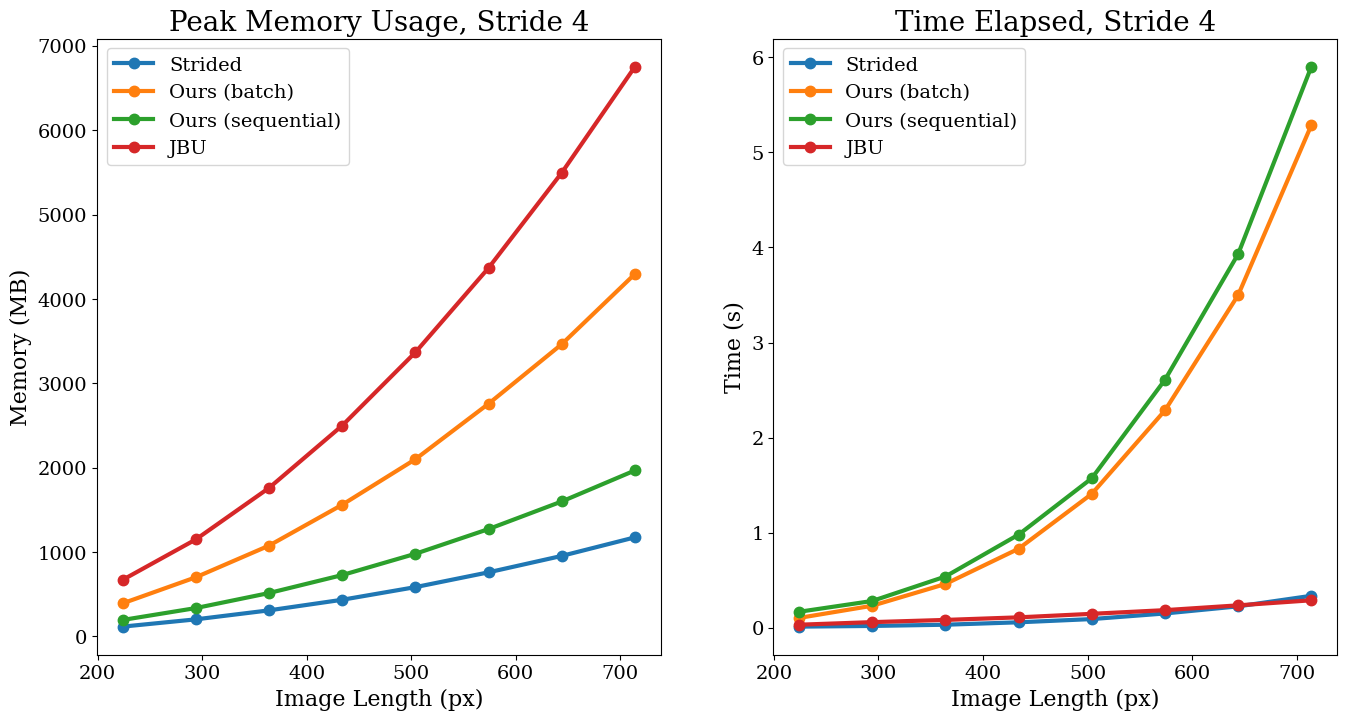

In [25]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(16, 8)

for j, i in enumerate(range(1, 9, 2)):
    data = np.asarray(out[i][1:])
    x = np.asarray(sizes)

    if j == 3:
        data = data / 2.0 #account for fp32 in jbu vs fp16 in ours
    axs[0].plot(x[1:], data, label=methods[j], marker='.', lw=3, ms=15)

for j, i in enumerate(range(0, 8, 2)):
    data = np.asarray(out[i][1:])
    x = np.asarray(sizes)

    axs[1].plot(x[1:], data, label=methods[j], marker='.', lw=3, ms=15)
format_plot(axs[0], "Peak Memory Usage, Stride 4", "Image Length (px)", "Memory (MB)", 20, 16, 14, 14)
format_plot(axs[1], "Time Elapsed, Stride 4", "Image Length (px)", "Time (s)", 20, 16, 14, 14)
plt.savefig('fig_out/supp_practical.png')